In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import math

import tensorflow as tf
import tensorflow.keras.datasets as tfds

import sklearn.datasets as skds

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut

# Lecture 6

## 1. SVM Fully Explained

[Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine), or SVM in short, is a supervised binary classification algorithms suitable for numerical data.


## 1.1 Theory

The main idea behind SVM is that our labeled data might be embedded in a vector space such that each cluster with different labels are separable via a hyperplane.  [Here](http://fourier.eng.hmc.edu/e161/lectures/svm/node1.html) is another good mathematical explanation of how and why SVM works.

In this setup, the data we have is a set of pairs $(x^{(i)},y^{(i)})$ where $x^{(i)}\in\mathbb{R}^n$ and $y^{(i)}=
\pm 1$ for every index $i=1,\ldots,N$.

Below, I will sample a random collection of points from $\mathbb{R}^2$ separable by many different hyperplanes.

Our dataset $\{x^{(i)}\}$ consists of points in a vector space $\mathbb{R}^n$, in other words each data point $x^{(i)}$ has $n$-components.  We also have a binary labelling scheme: each data point is labelled by one of two labels. For convenience, we choose these labels to be $+1$ and $-1$.

![img](../images/svm.png)

In the simplest version of the setup, the data is linearly separable, i.e. there is a hyperplane that sits in between class of points labelled as +1, and class of points labelled as -1.  Our aim is to find such a hyperplane with *the largest margin.*  The margin is the width of the gap on both sides of the hyperplane that fits between the datasets of different labels.

## 1.2 Some linear algebra

Recall from linear algebra that each hyperplane is determined by a normal vector $\mathbf{w}$ and a displacement $b$ from the origin.  Then the set of points on the hyperplane determined by $\mathbf{w}$ and displacement $b$ is given by

$$ \mathbf{w}\cdot\mathbf{x} + b = 0 $$

And this hyperplane splits our space into two disjoint subspaces: one subspace on one side of the hyperplane, while the other lies on the other side of the hyperplane.  More importantly for us, each side is determined by the sign of the displaced inner product.

$$ H_+ = \{ \mathbf{x}\in\mathbb{R}^n\mid \mathbf{w}\cdot\mathbf{x} + b > 0 \} $$
and
$$ H_- = \{ \mathbf{x}\in\mathbb{R}^n\mid \mathbf{w}\cdot\mathbf{x} + b < 0 \} $$


## 1.3 The optimization problem

From the argument above, we see that $\mathbf{w}$ and $b$ need to satisfy the following constraint on our dataset:

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) > 0 $$

Notice that $\mathbf{w}$ and $b$ do satisfy the constraint above then for every $\lambda>0$ we also have

$$ y^{(i)}(\lambda\mathbf{w}\cdot\mathbf{x}^{(i)}+\lambda b) > 0 $$

So, we choose a *normalization* for the pair of parameters $\mathbf{w}$ and $b$ and set

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$


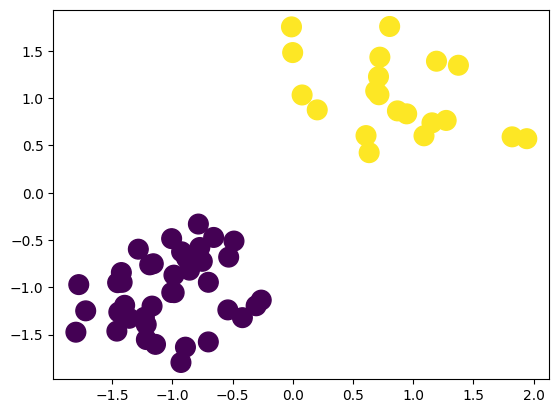

In [8]:
def randDisk(center,r,N):
    result = []
    x0,y0=center
    for i in range(N):
        r0 = np.random.normal(loc=r,scale=r/2)
        theta = np.random.uniform(0, 2*math.pi)
        result.append([x0+r0*math.cos(theta),y0+r0*math.sin(theta)])
    return result

tmp = randDisk([1,1],0.6,20)
tmp.extend(randDisk([-1,-1],0.5,40))

X = np.array(tmp)
v = [1,1]
y = [1 if np.dot(x,v)>0 else -1 for x in X]

plt.scatter(X[:,0],X[:,1],s=200,c=y)

Now, look at the picture above. We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

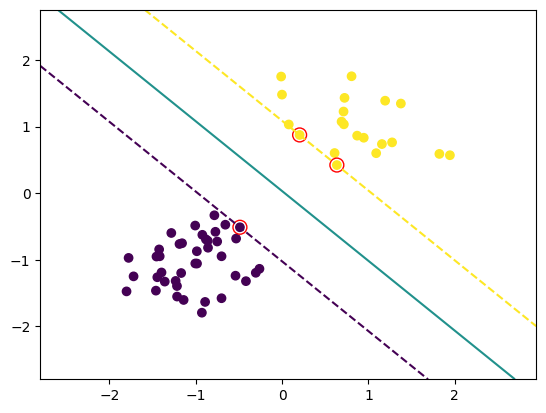

In [9]:
model = SVC(kernel="linear",C=1.05)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## 1.2 Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin** and we would like to allow some points being inside the margin. We call this situation as SVM classifier with *a soft margin*.  In mathematical terms, we do not strictly insist on the condition

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$

and allow points transgress the boundary with some error

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1-\xi_i $$

But this time we optimize

$$ \|\mathbf{w}\| + C \sum_{i=1}^N \xi_i^2 $$

where $C$ is a hyper-parameter we tune for the application at hand.

Please read [these lecture notes](http://fourier.eng.hmc.edu/e161/lectures/svm/node5.html) and [sklearn SVM with soft margins](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html) from the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html).

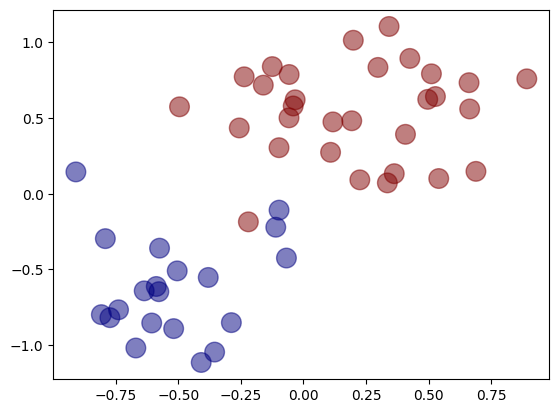

In [14]:
N1 = 30
N2 = 20

y = list([1]*N1 + [0]*N2)

new = randDisk([0.2,0.5],0.4,N1)
new.extend(randDisk([-0.5,-0.5],0.4,N2))
X = np.array(new)

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',s=200,alpha=0.5)

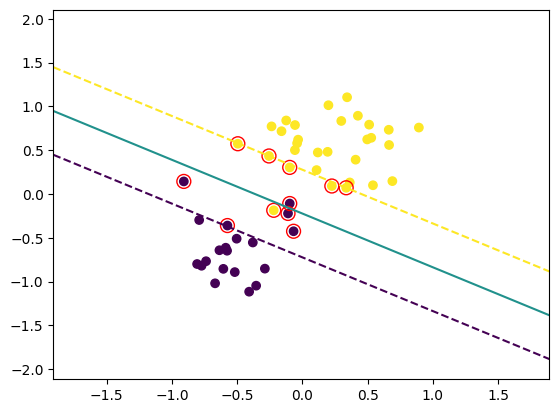

In [15]:
model = SVC(kernel="linear",C=1.0)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## 1.3 The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

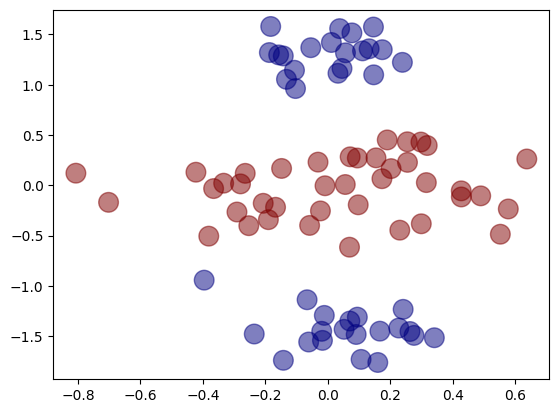

In [22]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.4],0.3,20))

X = np.array(tmp)
y = [1]*40 + [-1]*40

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',s=200,alpha=0.5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="poly",C=1.0,degree=2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0

## 1.4 Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

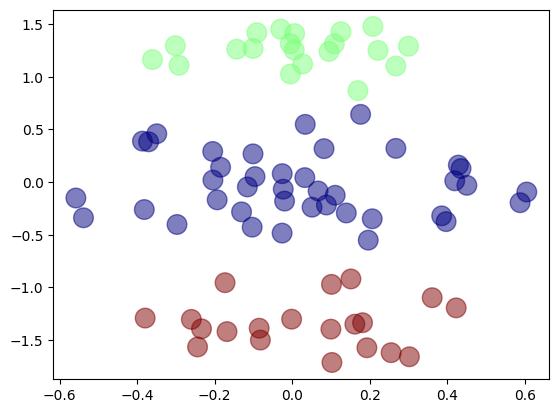

In [27]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))

X = np.array(tmp)
y = [1]*40 + [2]*20 + [3]*20

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',s=200,alpha=0.5)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="linear")
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0

# 2. REVIEW

In the last lecture we looked at logistic regression and SVM. The algorithm is one specific example of what we call *binary classification/clustering problems*.

## 2.1 Examples of classification/clustering algorithms

1. [k-means](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html): This is a clustering algorithm since it is unsupervised. We can set $k=2$ as well as $k>2$.

2. [k-nn](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4916348/): This is a classification algorithm since it is supervised. Again $k$ could be 2 or more.

3. [Logistic regression](https://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote06.html): This is again a classification algorithm. This time we can only split into 2 classes.

4. [SVM](https://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-and-machine-learning-on-documents-1.html): This is also a classification algorithm. It also works in cases where one has more than 2 classes.

## 2.2 Logistic Regression vs SVM

Let us consider the following two datasets:

In [46]:
radon = pd.read_csv('http://www.stat.columbia.edu/%7Egelman/arm/examples/radon/srrs2.dat',sep=',')
radon

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,...,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12772,12773,R5,WI,55,54660,4,1,0,4,Y,...,900,30388,30388,0.6,28.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12773,12774,R5,WI,55,54660,4,1,1,3,N,...,1615,30388,30388,2.2,14.5,4.761628,0,0,81,WISCONSIN WINNEBAGO
12774,12775,R5,WI,55,54660,4,1,1,3,Y,...,830,31588,31788,0.4,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12775,12776,R5,WI,55,54660,4,1,1,3,N,...,730,31588,31788,0.3,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO


In [47]:
radon.columns

Index(['idnum', ' state', ' state2', ' stfips', ' zip', ' region', ' typebldg',
       ' floor', ' room', ' basement', ' windoor', ' rep', ' stratum', ' wave',
       ' starttm', ' stoptm', ' startdt', ' stopdt', ' activity', ' pcterr',
       ' adjwt', ' dupflag', ' zipflag', ' cntyfips', ' county'],
      dtype='object')

In [48]:
radon_numerical = radon[[' region', ' typebldg', ' floor', ' room', ' stratum', 
                         ' starttm', ' stoptm', ' startdt', ' stopdt', ' activity', ' pcterr',' adjwt']]
radon_numerical

,region,typebldg,floor,room,stratum,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt
0,1,1,1,2,1,1100,1100,112987,120287,0.3,0.0,136.060971
1,1,0,9,0,1,600,700,70788,71188,0.6,33.3,128.784975
2,1,1,1,3,1,1145,1145,70788,70788,0.5,0.0,150.245112
3,1,1,1,3,1,1900,1900,52088,52288,0.6,97.2,136.060971
4,1,1,1,1,1,800,900,70788,70788,0.3,0.0,136.060971
...,...,...,...,...,...,...,...,...,...,...,...,...
12772,4,1,0,4,27,900,900,30388,30388,0.6,28.0,4.761628
12773,4,1,1,3,27,1530,1615,30388,30388,2.2,14.5,4.761628
12774,4,1,1,3,27,845,830,31588,31788,0.4,0.0,4.761628
12775,4,1,1,3,27,815,730,31588,31788,0.3,0.0,4.761628


In [49]:
radon_response = radon[' basement']
radon_response

0        N
1         
2        N
3        N
4        N
        ..
12772    Y
12773    N
12774    Y
12775    N
12776    Y
Name:  basement, Length: 12777, dtype: object

In [50]:
(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data() 
mnist = {'x_train': x_train, 'x_test': x_test,
         'y_train': y_train, 'y_test': y_test}

In [51]:
mnist['x_train'].shape

(60000, 28, 28)

In [52]:
mnist['y_train'].shape

(60000,)

### An Important Question

If we need to write a binary classification model, what should be used? LR or SVM? Why?

### Pros and Cons for LR vs SVM

* LR is relatively indifferent to the number of data points (rows) compared to SVM
* SVM is relatively indifferent to the number of features (columns) compared to LR
* LR models are explainable: you can interpret the model parameters
* SVM models are black box models: model parameters have no use

Both LR and SVM are binary classification models. So, we use similar model evaluation measures via confusion matrices:

* Accuracy
* Recall
* Precision
* F1-Score

### The Procedure

1. Choose a cross-validation method (k-fold, leave-one-out, MC, etc)
2. Write a function that takes a training set and a test set, and then returns one or all evaluation measures
3. Feed training and test sets to this function according to the CV method you chose, and record the evaluation metrics.
4. Apply an appropriate statistical test to get a confidence interval for your evaluation measures.

In [53]:
def experiment(X,y,model,N=10,test_size=0.1,train_size=0.9):
    scores = []

    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,train_size=train_size)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        scores.append(accuracy_score(y_predict, y_test))

    mean = np.mean(scores)
    return {'mean': mean, 
            'interval': st.t.interval(0.05, df=N-1, loc=mean, scale=st.sem(scores))}

In [54]:
y = LabelBinarizer().fit_transform(radon_response)[:,0]

%time experiment(radon_numerical, y, LogisticRegression(max_iter=1500),10)

CPU times: user 5.85 s, sys: 17.1 s, total: 22.9 s
Wall time: 3.12 s


{'mean': 0.9607198748043819,
 'interval': (0.960642151380463, 0.9607975982283008)}

In [55]:
%time experiment(radon_numerical,y,SVC(max_iter=1000),10)

/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solve

CPU times: user 5.22 s, sys: 726 ms, total: 5.94 s
Wall time: 5.33 s


/home/kaygun/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'mean': 0.9485133020344287,
 'interval': (0.9483863802146533, 0.9486402238542042)}

In [56]:
y = LabelBinarizer().fit_transform(mnist['y_train'])[:,8]
X = mnist['x_train'].reshape(60000,28*28)

%time experiment(X,y,SVC(),N=3,test_size=0.1,train_size=0.1)

CPU times: user 12.6 s, sys: 69.4 ms, total: 12.6 s
Wall time: 12.7 s


{'mean': 0.9814999999999999,
 'interval': (0.9814585602111384, 0.9815414397888614)}

In [57]:
%time experiment(X,y,LogisticRegression(max_iter=1000),N=3,test_size=0.1,train_size=0.1)

/home/kaygun/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kaygun/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

CPU times: user 1min 25s, sys: 30.3 s, total: 1min 55s
Wall time: 15.2 s


/home/kaygun/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'mean': 0.921611111111111,
 'interval': (0.9215360687074392, 0.9216861535147829)}

In [62]:
def getCM(X,y,model,test_size,train_size):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,train_size=train_size)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    return classification_report(y_test,y_predict)

In [68]:
y = LabelBinarizer().fit_transform(radon_response)[:,2]

print(getCM(radon_numerical,y,LogisticRegression(),0.25,0.75))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85      2355
           1       0.55      0.11      0.19       840

    accuracy                           0.74      3195
   macro avg       0.65      0.54      0.52      3195
weighted avg       0.70      0.74      0.67      3195



/home/kaygun/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
print(getCM(radon_numerical,y,SVC(),0.25,0.75))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      2300
           1       0.93      0.13      0.22       895

    accuracy                           0.75      3195
   macro avg       0.84      0.56      0.54      3195
weighted avg       0.80      0.75      0.68      3195



In [65]:
y = mnist['y_train']
X = mnist['x_train'].reshape(60000,28*28)

%time print(getCM(X,y,LogisticRegression(max_iter=1500),0.1,0.1))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       569
           1       0.91      0.96      0.93       658
           2       0.82      0.83      0.83       592
           3       0.84      0.84      0.84       630
           4       0.84      0.86      0.85       574
           5       0.79      0.73      0.76       509
           6       0.90      0.90      0.90       606
           7       0.90      0.89      0.90       664
           8       0.78      0.75      0.76       563
           9       0.85      0.85      0.85       635

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.85      6000
weighted avg       0.86      0.86      0.86      6000

CPU times: user 1min 45s, sys: 54.8 s, total: 2min 40s
Wall time: 21.5 s


/home/kaygun/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
%time print(getCM(X,y,SVC(max_iter=1000),0.1,0.1))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       594
           1       0.96      0.99      0.98       659
           2       0.95      0.95      0.95       608
           3       0.96      0.94      0.95       602
           4       0.95      0.96      0.95       584
           5       0.93      0.95      0.94       540
           6       0.96      0.97      0.97       573
           7       0.97      0.96      0.96       651
           8       0.95      0.92      0.94       608
           9       0.95      0.93      0.94       581

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

CPU times: user 14.3 s, sys: 483 ms, total: 14.8 s
Wall time: 14.3 s
